<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/rVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rotationally-invariant VAE: Application to arbitrary rotated 2D images


---

This notebook demonstrates how to apply a rotationally-invariant variational autoencoder (VAE) to the arbitrary rotated images of handwritten digits.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [ ]:
#@title Installation
!pip install -q pyroved kornia

In [ ]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#@title Helper functions
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    return images_r, pv.utils.to_onehot(mnist_trainset.targets, 10), theta

Get training data and create a dataloader object:

In [ ]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

/usr/local/lib/python3.7/dist-packages/kornia/geometry/transform/imgwarp.py:186: UserWarning: The align_corners default value has been changed. By default now is set True in order to match cv2.warpAffine. In case you want to keep your previous behaviour set it to False. This warning will disappear in kornia > v0.6.
  warnings.warn(message)


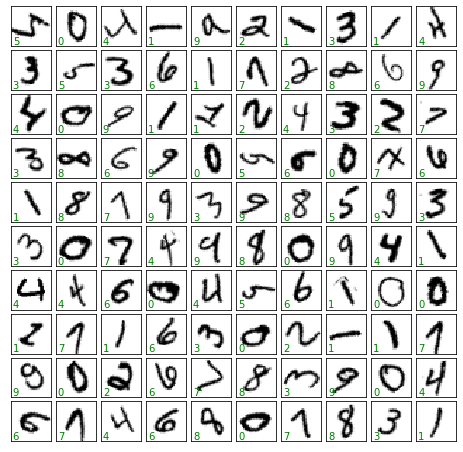

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im.squeeze(), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.argmax().item()),
            transform=ax.transAxes, color='green')

First, we explore the simple VAE:

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 224.8867
Epoch: 2 Training loss: 192.3686
Epoch: 3 Training loss: 186.2782
Epoch: 4 Training loss: 182.7144
Epoch: 5 Training loss: 180.4599
Epoch: 6 Training loss: 178.7519
Epoch: 7 Training loss: 177.2925
Epoch: 8 Training loss: 175.9412
Epoch: 9 Training loss: 174.8820
Epoch: 10 Training loss: 173.9328
Epoch: 11 Training loss: 173.0766
Epoch: 12 Training loss: 172.3841
Epoch: 13 Training loss: 171.7350
Epoch: 14 Training loss: 171.1912
Epoch: 15 Training loss: 170.6122
Epoch: 16 Training loss: 170.1624
Epoch: 17 Training loss: 169.7664
Epoch: 18 Training loss: 169.3459
Epoch: 19 Training loss: 168.9485
Epoch: 20 Training loss: 168.6261
Epoch: 21 Training loss: 168.3185
Epoch: 22 Training loss: 168.0745
Epoch: 23 Training loss: 167.8361
Epoch: 24 Training loss: 167.5085
Epoch: 25 Training loss: 167.2844
Epoch: 26 Training loss: 167.1039
Epoch: 27 Training loss: 166.9308
Epoch: 28 Training loss: 166.6231
Epoch: 29 Training loss: 166.4915
Epoch: 30 Training loss

Visualize the learned latent manifold:

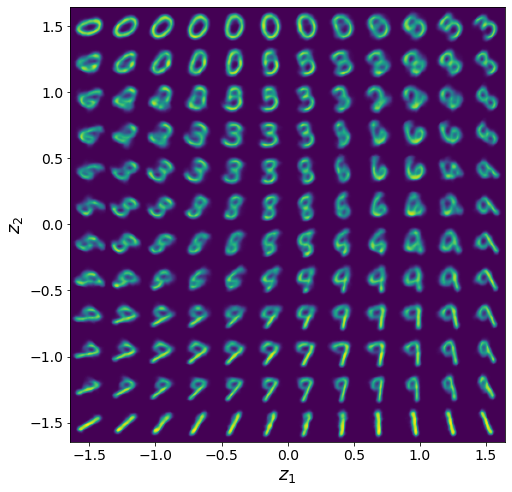

In [ ]:
vae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

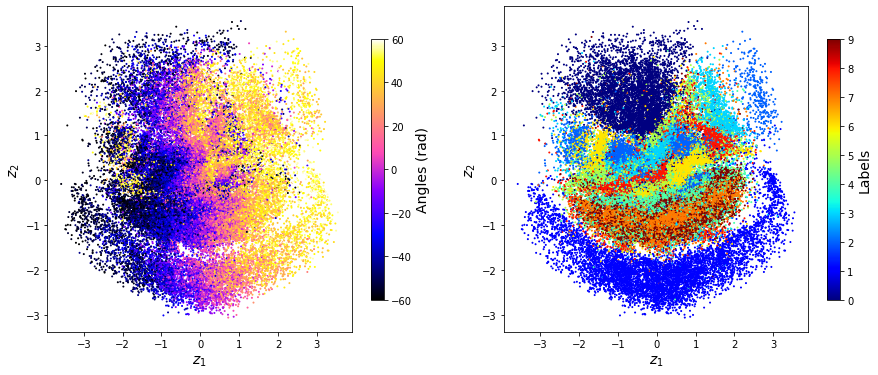

In [ ]:
z_mean, z_sd = vae.encode(train_data)
_, labels = torch.max(train_labels, 1)
labels = labels.cpu().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

The examination of latent space shows that the angle changes along the first latent direction, whereas the digit changes mostly along the second latent dimension. This clearly illustrates the disentanglement of the data representation concept, where the rotational angle and class emerge as the two most prominent factors of variation within the data.

Now let's train VAE with rotational invariance (aka rVAE):

In [ ]:
# Reinitialize dataloader
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae = pv.models.iVAE(in_dim, latent_dim=2, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 250.5616
Epoch: 2 Training loss: 206.4766
Epoch: 3 Training loss: 197.0023
Epoch: 4 Training loss: 191.6669
Epoch: 5 Training loss: 187.2047
Epoch: 6 Training loss: 184.0478
Epoch: 7 Training loss: 182.0111
Epoch: 8 Training loss: 180.3159
Epoch: 9 Training loss: 178.9715
Epoch: 10 Training loss: 178.0622
Epoch: 11 Training loss: 177.2772
Epoch: 12 Training loss: 176.4970
Epoch: 13 Training loss: 176.0549
Epoch: 14 Training loss: 175.3369
Epoch: 15 Training loss: 174.7044
Epoch: 16 Training loss: 174.3017
Epoch: 17 Training loss: 173.8871
Epoch: 18 Training loss: 173.3014
Epoch: 19 Training loss: 173.0822
Epoch: 20 Training loss: 172.6847
Epoch: 21 Training loss: 172.3612
Epoch: 22 Training loss: 172.0020
Epoch: 23 Training loss: 171.6393
Epoch: 24 Training loss: 171.4202
Epoch: 25 Training loss: 171.0164
Epoch: 26 Training loss: 170.8633
Epoch: 27 Training loss: 170.4082
Epoch: 28 Training loss: 170.1794
Epoch: 29 Training loss: 170.0253
Epoch: 30 Training loss

Visualize the learned latent manifold:

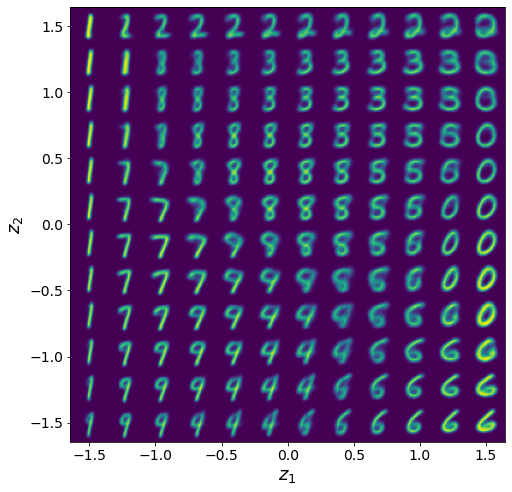

In [ ]:
rvae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

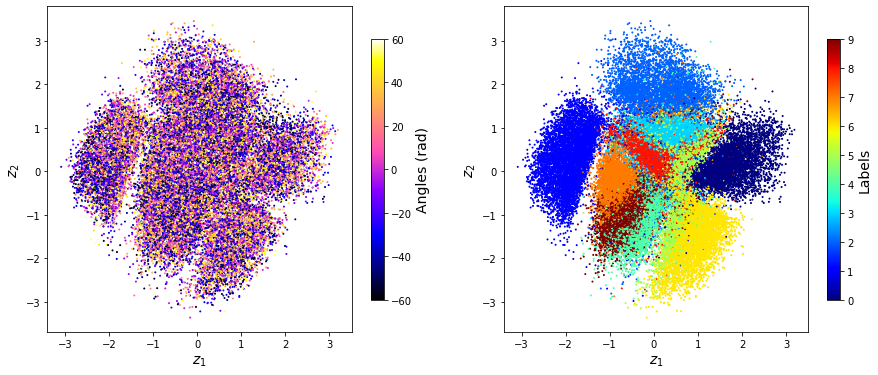

In [ ]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In this case, the digits in the latent space are oriented in one direction. The latent space shows that the angles are now random, whereas the digits form well-defined clusters (rather remarkable given that we encode the data set using only two latent variables). We also get the angle as one of the latent variables, and the latent angle and ground truth angle are compared in the figure above. Note that they are linearly related, but at the same time latent angles have broad distribution. This is unsurprising since an angle is one of the characteristics of handwriting style and varies from person to person! The latent representation we discovered hence compensated by this fact via introducing it as an additional augmentation variable, and then separating it from other factors of variation.


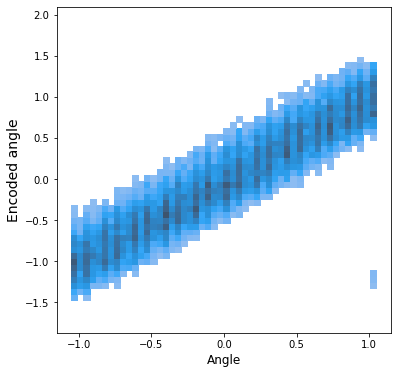

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=torch.deg2rad(angles.float()), y=z_mean[:, 0], bins=50, pthresh=.1);

Finally, we illustrate the class-conditioned rVAE (crVAE) applied to this data set. Note that the only two things we have to do is add labels to our data loader and specify number of classes when initializing the crVAE model - pyroVED will take care of the rest.

In [ ]:
# Initialize dataloader (here we are adding labels to the training data)
train_loader = pv.utils.init_dataloader(train_data, train_labels, batch_size=200)

In [ ]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae = pv.models.iVAE(in_dim, latent_dim=2, num_classes=10, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(crvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 242.3101
Epoch: 2 Training loss: 192.3947
Epoch: 3 Training loss: 180.5050
Epoch: 4 Training loss: 174.6526
Epoch: 5 Training loss: 171.1777
Epoch: 6 Training loss: 169.2620
Epoch: 7 Training loss: 166.6892
Epoch: 8 Training loss: 164.8139
Epoch: 9 Training loss: 163.5983
Epoch: 10 Training loss: 162.9162
Epoch: 11 Training loss: 162.1721
Epoch: 12 Training loss: 161.3899
Epoch: 13 Training loss: 160.9357
Epoch: 14 Training loss: 160.4600
Epoch: 15 Training loss: 160.0112
Epoch: 16 Training loss: 159.8124
Epoch: 17 Training loss: 159.3172
Epoch: 18 Training loss: 159.0908
Epoch: 19 Training loss: 158.7662
Epoch: 20 Training loss: 158.5724
Epoch: 21 Training loss: 158.4320
Epoch: 22 Training loss: 158.1583
Epoch: 23 Training loss: 157.8699
Epoch: 24 Training loss: 158.0427
Epoch: 25 Training loss: 157.5278
Epoch: 26 Training loss: 157.4859
Epoch: 27 Training loss: 157.2277
Epoch: 28 Training loss: 157.0278
Epoch: 29 Training loss: 156.9137
Epoch: 30 Training loss

View the learned latent manifold for each class:

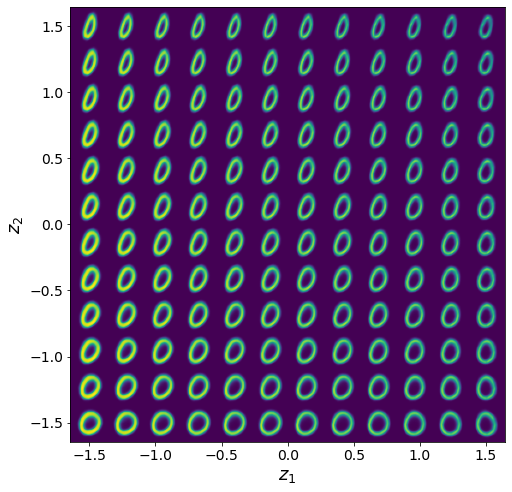

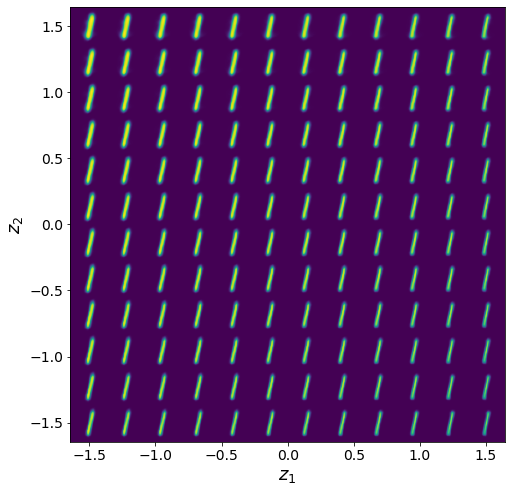

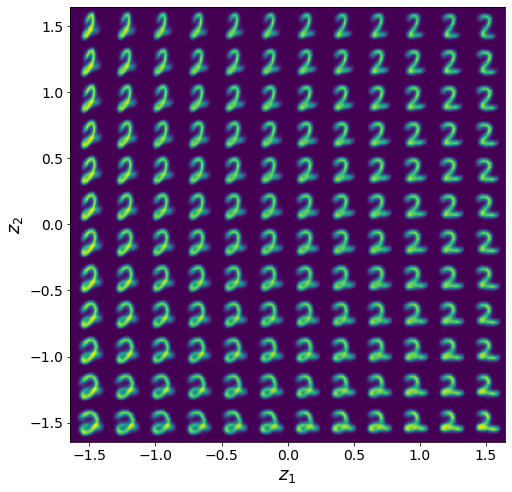

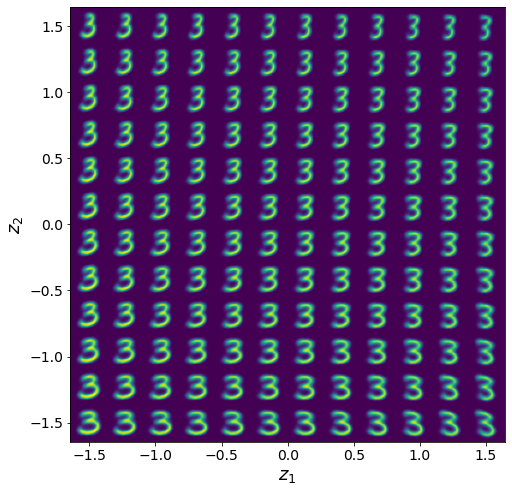

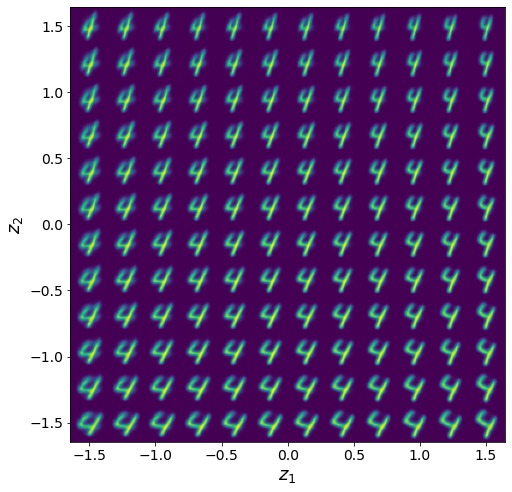

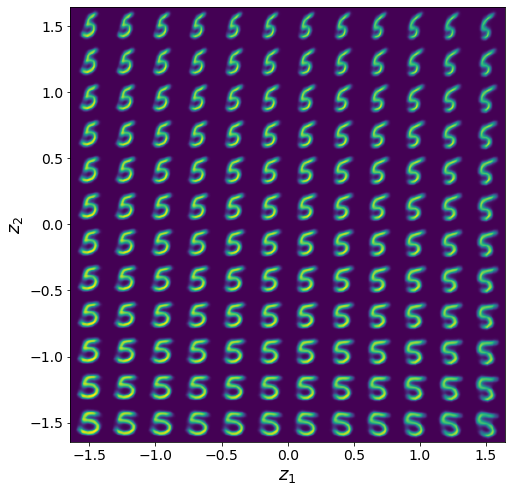

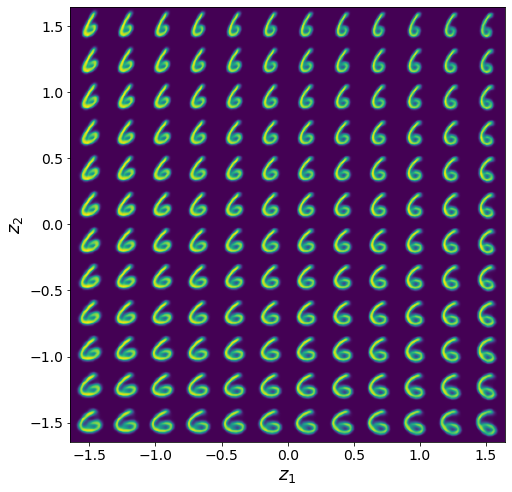

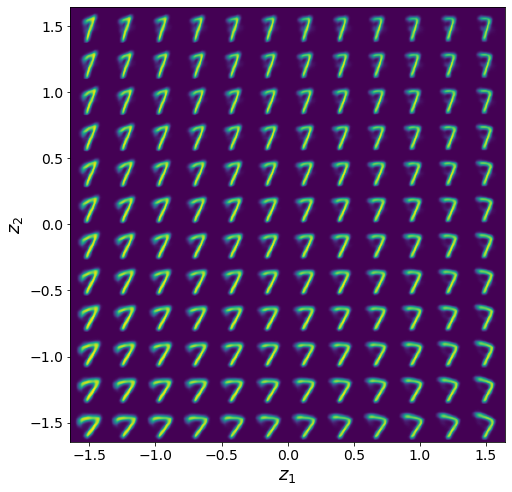

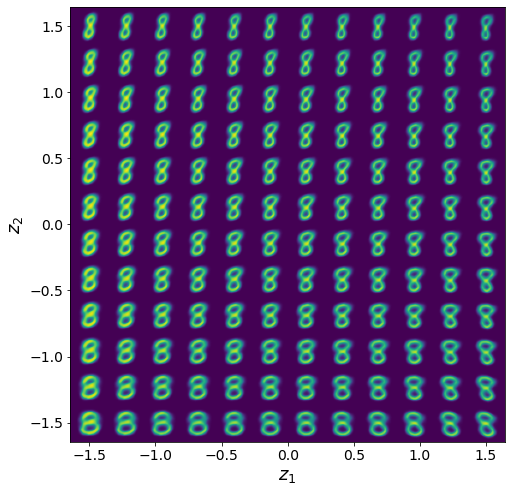

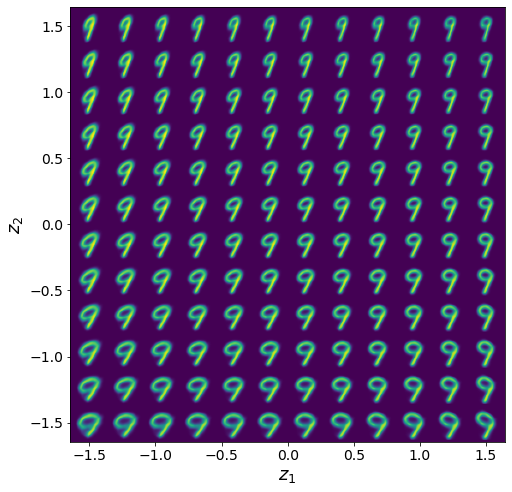

In [ ]:
for i in range(10):
    crvae.manifold2d(d=12, label=i, cmap="viridis")

In this case, our latent reconstructions clearly show that within each latent space, the digits are oriented in the same direction, and latent variables now encode very subtle details of the handwriting styles.

Encode all the data and view the encoded values as a scatter plot:

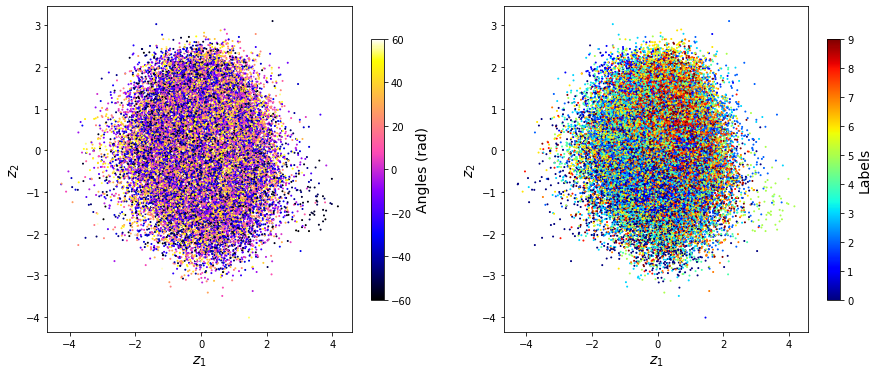

In [ ]:
z_mean, z_sd = crvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10)